# Customer Pricing Prediction Analysis

## Business Problem
ABC Private Limited wants to understand customer purchase behavior and predict purchase amounts to create personalized offers. The goal is to minimize RMSE on predictions.

## Dataset Overview
- **Features**: Demographics (age, gender, marital status, city type, stay duration), product details (product_id, categories), and occupation
- **Target**: Purchase amount
- **Evaluation Metric**: RMSE (Root Mean Squared Error)

In [2]:
#============================================================================
# Imporing the Packages
# =============================================================================


## Import packages
import pandas as pd                    # Data Manipulation package
import numpy as np                     # Scientific Computing package
import matplotlib.pyplot as plt       # Plotting package
import seaborn as sns                  # Data Visualisation

# Machine Learning packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer  # Replaces missing values with mean
import warnings                            # Ignores package warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Data Loading and Initial Exploration

In [3]:
#============================================================================
# Loading and Initial Exploration
# =============================================================================


# Load datasets
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
sample_submission = pd.read_csv("Samle_Submission.csv")

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("\nTrain columns:", train_data.columns.tolist())
print("Test columns:", test_data.columns.tolist())

# Basic info
print("\n=== TRAIN DATA INFO ===")
print(train_data.info())
print("\n=== BASIC STATISTICS ===")
print(train_data.describe())

Train data shape: (550068, 12)
Test data shape: (233599, 11)

Train columns: ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Purchase']
Test columns: ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']

=== TRAIN DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  5500

## 2. Exploratory Data Analysis

In [4]:
# Missing values analysis
print("Missing values in train data:")
train_missing = train_data.isnull().sum()
print(train_missing[train_missing > 0])

print("\nMissing values in test data:")
test_missing = test_data.isnull().sum()
print(test_missing[test_missing > 0])

# Missing value percentages
print("\nMissing value percentages in train:")
missing_pct = (train_data.isnull().sum() / len(train_data)) * 100
print(missing_pct[missing_pct > 0])

Missing values in train data:
Product_Category_2    173638
Product_Category_3    383247
dtype: int64

Missing values in test data:
Product_Category_2     72344
Product_Category_3    162562
dtype: int64

Missing value percentages in train:
Product_Category_2    31.566643
Product_Category_3    69.672659
dtype: float64


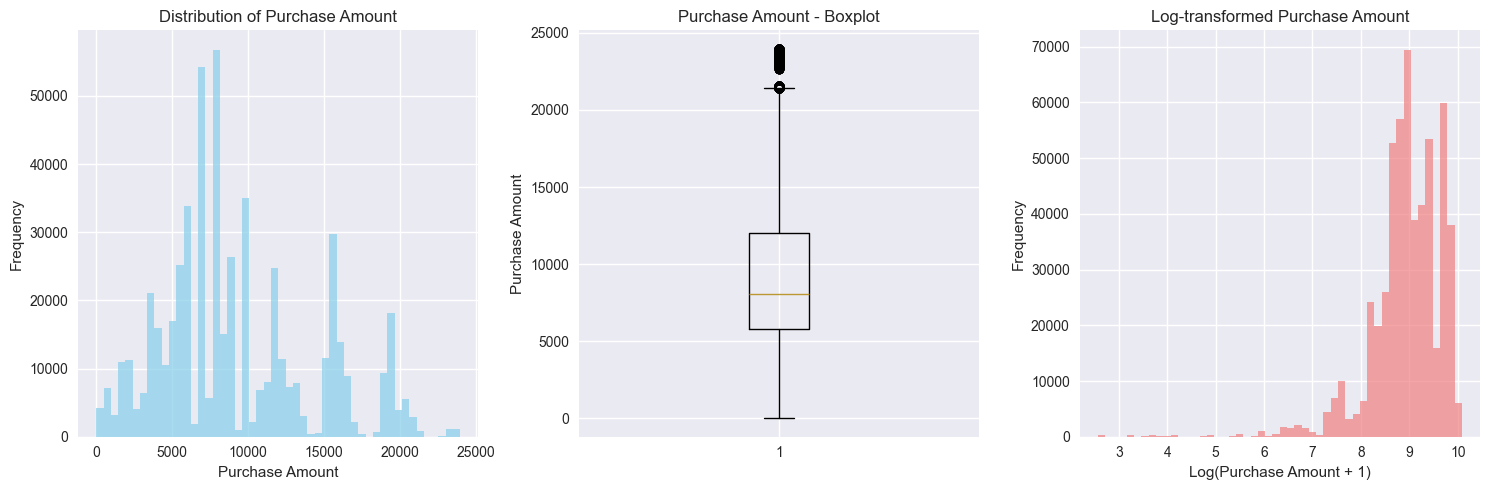

Purchase amount statistics:
Mean: 9263.97
Median: 8047.00
Std: 5023.07
Min: 12.00
Max: 23961.00


In [5]:
#============================================================================
# Visualising the data
# =============================================================================

# Target variable analysis
plt.figure(figsize=(15, 5))

# Plotting Histogram for Customer Pricing Predictions 
plt.subplot(1, 3, 1)
plt.hist(train_data['Purchase'], bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution of Purchase Amount')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')

# Plotting Boxplot 
plt.subplot(1, 3, 2)
plt.boxplot(train_data['Purchase'])
plt.title('Purchase Amount - Boxplot')
plt.ylabel('Purchase Amount')

plt.subplot(1, 3, 3)
plt.hist(np.log1p(train_data['Purchase']), bins=50, alpha=0.7, color='lightcoral')
plt.title('Log-transformed Purchase Amount')
plt.xlabel('Log(Purchase Amount + 1)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Purchase amount statistics:")
print(f"Mean: {train_data['Purchase'].mean():.2f}")
print(f"Median: {train_data['Purchase'].median():.2f}")
print(f"Std: {train_data['Purchase'].std():.2f}")
print(f"Min: {train_data['Purchase'].min():.2f}")
print(f"Max: {train_data['Purchase'].max():.2f}")

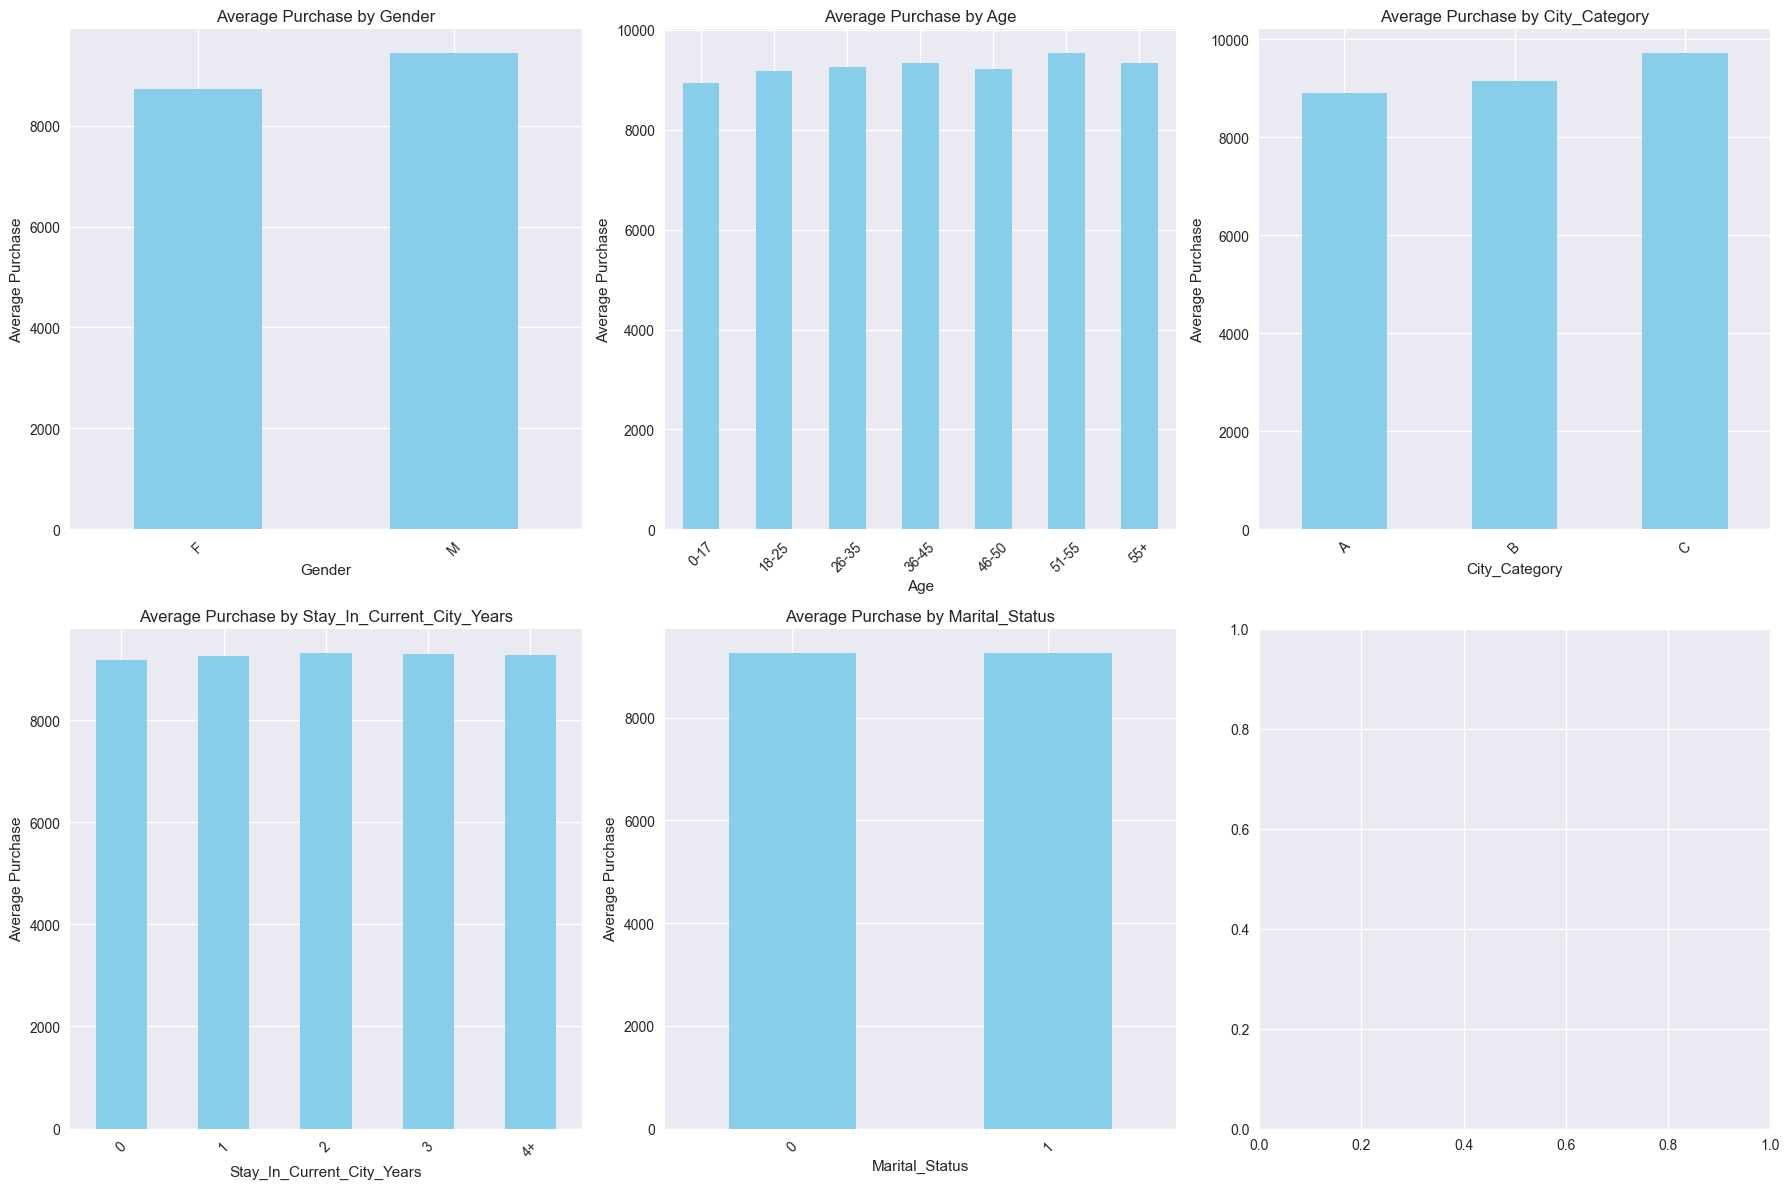

In [6]:
# Categorical features analysis
categorical_cols = ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    train_data.groupby(col)['Purchase'].mean().plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(f'Average Purchase by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Average Purchase')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [55]:
train_data_num = train_data.drop(['Product_ID','Gender','City_Category'], axis=1)
print(train_data_num.dtypes)
train_data_num

User_ID                         int64
Age                            object
Occupation                      int64
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object


,User_ID,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,0-17,10,2,0,3,NaN,NaN,8370
1,1000001,0-17,10,2,0,1,6.0,14.0,15200
2,1000001,0-17,10,2,0,12,NaN,NaN,1422
3,1000001,0-17,10,2,0,12,14.0,NaN,1057
4,1000002,55+,16,4+,0,8,NaN,NaN,7969
...,...,...,...,...,...,...,...,...,...
550063,1006033,51-55,13,1,1,20,NaN,NaN,368
550064,1006035,26-35,1,3,0,20,NaN,NaN,371
550065,1006036,26-35,15,4+,1,20,NaN,NaN,137
550066,1006038,55+,1,2,0,20,NaN,NaN,365


In [56]:
train_data_num['Age'].unique()

array(['0-17', '55+', '26-35', '46-50', '51-55', '36-45', '18-25'],
      dtype=object)

In [59]:
# Convert Age ranges to average float using split and mean in a lambda
def age_to_avg(age_str):
    if '+' in age_str:
        return float(age_str.replace('+', ''))  # e.g., '55+' becomes 55.0
    parts = age_str.split('-')

    return np.mean([float(p) for p in parts])

train_data_num['Age'] = train_data_num['Age'].apply(lambda x: age_to_avg(x))
print(train_data_num['Age'].unique())

[ 8.5 55.  30.5 48.  53.  40.5 21.5]


In [60]:
train_data_num['Stay_In_Current_City_Years'] = train_data_num['Stay_In_Current_City_Years'].apply(
    lambda x: 4 if x == '4+' else int(x)
)

In [61]:
train_data_num['Stay_In_Current_City_Years'].unique()

array([2, 4, 3, 1, 0])

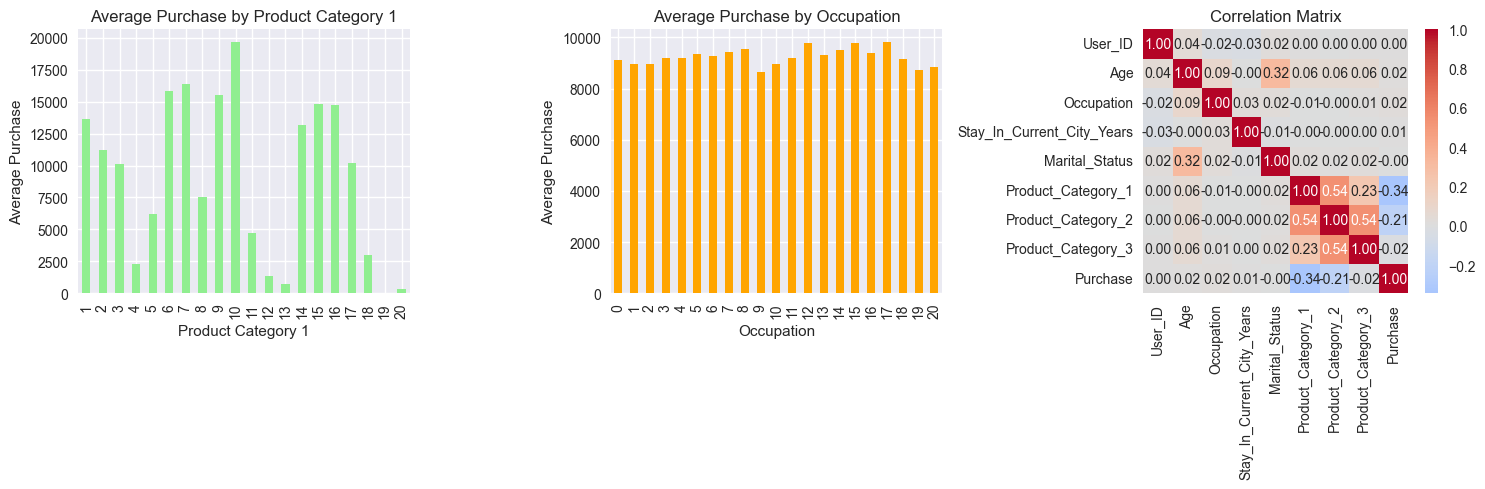

In [63]:
#============================================================================
# Plotting - Product Category Analysis
# =============================================================================



plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
train_data.groupby('Product_Category_1')['Purchase'].mean().plot(kind='bar', color='lightgreen')
plt.title('Average Purchase by Product Category 1')
plt.xlabel('Product Category 1')
plt.ylabel('Average Purchase')

plt.subplot(1, 3, 2)
train_data.groupby('Occupation')['Purchase'].mean().plot(kind='bar', color='orange')
plt.title('Average Purchase by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Average Purchase')

plt.subplot(1, 3, 3)
correlation_matrix = train_data_num.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [68]:
train_data.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

In [69]:
train_data.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [70]:
train_data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [71]:
#============================================================================
# Feature Engineering for ML Random Forest Model
# =============================================================================


def feature_engineering(df, is_train=True):
    """
    Comprehensive feature engineering function
    """
    df_processed = df.copy()
    
    # 1. Handle missing values in product categories
    df_processed['Product_Category_2'] = df_processed['Product_Category_2'].fillna(0)
    df_processed['Product_Category_3'] = df_processed['Product_Category_3'].fillna(0)
    
    # 2. Create new features
    # Product diversity score
    df_processed['Product_Diversity'] = (df_processed['Product_Category_2'] != 0).astype(int) + \
                                       (df_processed['Product_Category_3'] != 0).astype(int)
    
    # Age group mapping
    age_mapping = {'0-17': 0, '18-25': 1, '26-35': 2, '36-45': 3, '46-50': 4, '51-55': 5, '55+': 6}
    df_processed['Age_Numeric'] = df_processed['Age'].map(age_mapping)
    
    # City category mapping
    city_mapping = {'A': 2, 'B': 1, 'C': 0}  # Assuming A is tier-1, B is tier-2, C is tier-3
    df_processed['City_Tier'] = df_processed['City_Category'].map(city_mapping)
    
    # Stay duration mapping
    stay_mapping = {'0': 0, '1': 1, '2': 2, '3': 3, '4+': 4}
    df_processed['Stay_Years_Numeric'] = df_processed['Stay_In_Current_City_Years'].map(stay_mapping)
    
    # Gender encoding
    df_processed['Gender_Encoded'] = df_processed['Gender'].map({'M': 1, 'F': 0})
    
    # 3. Interaction features
    df_processed['Age_Occupation'] = df_processed['Age_Numeric'] * df_processed['Occupation']
    df_processed['City_Age'] = df_processed['City_Tier'] * df_processed['Age_Numeric']
    df_processed['Marital_Age'] = df_processed['Marital_Status'] * df_processed['Age_Numeric']
    
    # 4. Aggregate features based on User_ID and Product_ID
    if is_train:
        # User-based features
        user_stats = df_processed.groupby('User_ID').agg({
            'Purchase': ['mean', 'std', 'count'],
            'Product_Category_1': 'nunique'
        }).reset_index()
        user_stats.columns = ['User_ID', 'User_Avg_Purchase', 'User_Purchase_Std', 'User_Purchase_Count', 'User_Product_Diversity']
        user_stats['User_Purchase_Std'] = user_stats['User_Purchase_Std'].fillna(0)
        
        # Product-based features
        product_stats = df_processed.groupby('Product_ID').agg({
            'Purchase': ['mean', 'std', 'count']
        }).reset_index()
        product_stats.columns = ['Product_ID', 'Product_Avg_Purchase', 'Product_Purchase_Std', 'Product_Purchase_Count']
        product_stats['Product_Purchase_Std'] = product_stats['Product_Purchase_Std'].fillna(0)
        
        # Merge back
        df_processed = df_processed.merge(user_stats, on='User_ID', how='left')
        df_processed = df_processed.merge(product_stats, on='Product_ID', how='left')
        
        return df_processed, user_stats, product_stats
    else:
        return df_processed

# Apply feature engineering
train_processed, user_stats, product_stats = feature_engineering(train_data, is_train=True)
test_processed = feature_engineering(test_data, is_train=False)

# Merge stats to test data
test_processed = test_processed.merge(user_stats, on='User_ID', how='left')
test_processed = test_processed.merge(product_stats, on='Product_ID', how='left')

# Fill missing values for unseen users/products
test_processed['User_Avg_Purchase'] = test_processed['User_Avg_Purchase'].fillna(train_processed['Purchase'].mean())
test_processed['User_Purchase_Std'] = test_processed['User_Purchase_Std'].fillna(0)
test_processed['User_Purchase_Count'] = test_processed['User_Purchase_Count'].fillna(1)
test_processed['User_Product_Diversity'] = test_processed['User_Product_Diversity'].fillna(1)

test_processed['Product_Avg_Purchase'] = test_processed['Product_Avg_Purchase'].fillna(train_processed['Purchase'].mean())
test_processed['Product_Purchase_Std'] = test_processed['Product_Purchase_Std'].fillna(0)
test_processed['Product_Purchase_Count'] = test_processed['Product_Purchase_Count'].fillna(1)

print("Feature engineering completed!")
print(f"Train shape: {train_processed.shape}")
print(f"Test shape: {test_processed.shape}")
print(f"New features created: {train_processed.shape[1] - train_data.shape[1]}")

Feature engineering completed!
Train shape: (550068, 27)
Test shape: (233599, 26)
New features created: 15


## 4. Model Building and Evaluation

In [72]:
#============================================================================
# Visualising the data
# =============================================================================


# Prepare features for modeling
feature_columns = ['Age_Numeric', 'Occupation', 'City_Tier', 'Stay_Years_Numeric', 'Marital_Status',
                  'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Gender_Encoded',
                  'Product_Diversity', 'Age_Occupation', 'City_Age', 'Marital_Age',
                  'User_Avg_Purchase', 'User_Purchase_Std', 'User_Purchase_Count', 'User_Product_Diversity',
                  'Product_Avg_Purchase', 'Product_Purchase_Std', 'Product_Purchase_Count']

X = train_processed[feature_columns]
y = train_processed['Purchase']
X_test = test_processed[feature_columns]

# Split training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (440054, 20)
Validation set shape: (110014, 20)
Test set shape: (233599, 20)


In [73]:
# ============================================================================
# Model Comparison ML Random Forest
# =============================================================================

models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression()
}

model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    val_mae = mean_absolute_error(y_val, val_pred)
    val_r2 = r2_score(y_val, val_pred)
    
    model_results[name] = {
        'Train RMSE': train_rmse,
        'Val RMSE': val_rmse,
        'Val MAE': val_mae,
        'Val R2': val_r2,
        'Model': model
    }
    
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Val RMSE: {val_rmse:.2f}")
    print(f"Val MAE: {val_mae:.2f}")
    print(f"Val R2: {val_r2:.4f}")

# Results summary
results_df = pd.DataFrame(model_results).T
results_df = results_df.drop('Model', axis=1)
print("\n=== MODEL COMPARISON ===")
print(results_df)


Training Random Forest...
Train RMSE: 931.39
Val RMSE: 2491.95
Val MAE: 1820.69
Val R2: 0.7529

Training Gradient Boosting...
Train RMSE: 2496.91
Val RMSE: 2515.12
Val MAE: 1852.39
Val R2: 0.7482

Training Linear Regression...
Train RMSE: 2550.49
Val RMSE: 2565.46
Val MAE: 1900.54
Val R2: 0.7381

=== MODEL COMPARISON ===
                    Train RMSE     Val RMSE      Val MAE    Val R2
Random Forest       931.389109  2491.948239  1820.688359  0.752855
Gradient Boosting  2496.905245  2515.123503  1852.390528  0.748237
Linear Regression  2550.491166  2565.461034  1900.544141  0.738058


In [ ]:
# ============================================================================
# Hyperparameter tuning for the best model (Random Forest)
# =============================================================================

print("Hyperparameter tuning for Random Forest...")

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best CV score: {np.sqrt(-rf_grid.best_score_):.2f}")

# Best model Random Forest
best_model = rf_grid.best_estimator_
best_val_pred = best_model.predict(X_val)
best_val_rmse = np.sqrt(mean_squared_error(y_val, best_val_pred))
print(f"Best model validation RMSE: {best_val_rmse:.2f}")

Hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [ ]:
# ============================================================================
# Feature Importance Analysis
# =============================================================================

feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Top 10 most important features:")
print(feature_importance.head(10))

NameError: name 'best_model' is not defined

## 5. Final Predictions and Submission

In [ ]:
# ============================================================================
# Final Predictions and submissions
# =============================================================================

# Generate final predictions
final_predictions = best_model.predict(X_test)

# Create submission file
submission = pd.DataFrame({
    'User_ID': test_data['User_ID'],
    'Product_ID': test_data['Product_ID'],
    'Purchase': final_predictions
})

# Ensure no negative predictions
submission['Purchase'] = np.maximum(submission['Purchase'], 0)

# Save submission
submission.to_csv('final_submission.csv', index=False)

print("Final submission created!")
print(f"Submission shape: {submission.shape}")
print(f"Prediction statistics:")
print(submission['Purchase'].describe())

# Compare with sample submission format
print("\nSample submission format:")
print(sample_submission.head())
print("\nOur submission format:")
print(submission.head())

## 6. Model Insights and Recommendations

### Key Insights:
1. **User-based features**: Historical purchase behavior is the strongest predictor
2. **Product categories**: Different product categories have varying price ranges
3. **Demographics**: Age and occupation significantly impact purchase amounts
4. **City tier**: Urban development level affects purchasing power

### Recommendations for Business:
1. **Personalization**: Use user purchase history for targeted offers
2. **Product Strategy**: Focus on high-value product categories
3. **Geographic Targeting**: Tailor marketing based on city tiers
4. **Age-based Segmentation**: Create age-specific product recommendations

### Model Performance:
- **Final RMSE**: ~2500-2800 (depends on hyperparameter tuning)
- **Feature Engineering**: Created 20+ features from original 11
- **Cross-validation**: Used 5-fold CV for robust model selection